# Loading exposure and claims data

Check Python environment

In [1]:
import os
os.getcwd()

'C:\\Users\\Alex\\Documents\\repos\\French-Insurance-Modelling-Data'

In [2]:
import sys
#print(sys.executable)

import warnings
warnings.filterwarnings('ignore')


In [3]:
#!pip list

Importing packages

In [4]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scipy
from scipy import special

from sklearn.datasets import fetch_openml



Loading claims and exposure data

In [5]:
def load_claim_data(n_samples=None):
    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True, parser="pandas").data
    df_sev["IDpol"] = df_sev["IDpol"].astype('int')
    df_sev=df_sev.sort_values("IDpol")
    return df_sev.iloc[:n_samples]
    

In [6]:
def load_expo_data(n_samples=None):
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True, parser="pandas").data
    df_freq["IDpol"] = df_freq["IDpol"].astype('int')
    df_freq = df_freq.sort_values("IDpol")
    return df_freq.iloc[:n_samples]

In [7]:
claim_data = load_claim_data()

In [8]:
claim_data


,IDpol,ClaimAmount
2966,139,303.00
2839,190,1981.84
1354,414,1456.55
2164,424,9844.36
689,424,989.64
...,...,...
2659,6113793,1769.88
2551,6113817,1288.28
2665,6113834,1940.40
2664,6113834,10290.00


In [9]:
expo_data = load_expo_data()

In [10]:
expo_data

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
1,3,1,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
2,5,1,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
3,10,1,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
4,11,1,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
678009,6114327,0,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
678010,6114328,0,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82
678011,6114329,0,0.00274,B,4,0,60,50,B12,'Regular',95,R26


# Merging data and restricting analysis to non-zero claims

i) Merge claims data onto exposure data, so have data on individual claims with covariates
ii) Restricting to all no-null claims. I.e claims where claimsize>0

In [11]:
claim_data = pd.merge(expo_data,claim_data,on = "IDpol",how='left')
claim_data=claim_data[claim_data['ClaimAmount']>0]
claim_data['ClaimAmount']=np.round(claim_data['ClaimAmount'],0)
claim_data['ClaimAmount']=claim_data['ClaimAmount'].astype('int')

In [12]:
columns_to_remove = ['ClaimNb']
claim_data = claim_data.drop(columns=columns_to_remove)
claim_data

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
66,139,0.75,F,7,1,61,50,B12,'Regular',27000,R11,303
93,190,0.14,B,12,5,50,60,B12,'Diesel',56,R25,1982
199,414,0.14,E,4,0,36,85,B12,'Regular',4792,R11,1457
205,424,0.62,F,10,0,51,100,B12,'Regular',27000,R11,9844
206,424,0.62,F,10,0,51,100,B12,'Regular',27000,R11,990
...,...,...,...,...,...,...,...,...,...,...,...,...
678974,6113793,0.14,C,7,2,51,50,B12,'Diesel',178,R72,1770
678998,6113817,0.17,D,4,0,35,51,B12,'Regular',1719,R82,1288
679015,6113834,0.17,C,15,3,36,50,B12,'Regular',181,R54,1940
679016,6113834,0.17,C,15,3,36,50,B12,'Regular',181,R54,10290


Defining number of (non-null) claims based on (non-null) claims data

In [13]:
number_of_claims = pd.DataFrame(claim_data.groupby('IDpol').agg({'IDpol':'first','ClaimAmount':'count'})).reset_index(drop=True)
number_of_claims = number_of_claims.rename(columns= {'ClaimAmount':'N'})
number_of_claims
                                           



,IDpol,N
0,139,1
1,190,1
2,414,1
3,424,2
4,463,1
...,...,...
24939,6113521,1
24940,6113793,1
24941,6113817,1
24942,6113834,2


Merging number of claims and IDpol onto exposure data so to be able to model claims frequency 


In [14]:
expo_data = pd.merge(expo_data,number_of_claims,how="left", on = 'IDpol')
expo_data['N'] = expo_data['N'].fillna(0)
expo_data['N']=expo_data['N'].astype('int')
expo_data
columns_to_remove = ['ClaimNb']
expo_data = expo_data.drop(columns=columns_to_remove)

In [15]:
expo_data

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,N
0,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82,0
1,3,0.77000,D,5,0,55,50,B12,'Regular',1217,R82,0
2,5,0.75000,B,6,2,52,50,B12,'Diesel',54,R22,0
3,10,0.09000,B,7,0,46,50,B12,'Diesel',76,R72,0
4,11,0.84000,B,7,0,46,50,B12,'Diesel',76,R72,0
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0.00274,E,4,0,54,50,B12,'Regular',3317,R93,0
678009,6114327,0.00274,E,4,0,41,95,B12,'Regular',9850,R11,0
678010,6114328,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82,0
678011,6114329,0.00274,B,4,0,60,50,B12,'Regular',95,R26,0


In [16]:
condition = expo_data['N'] > 0
selected_rows = expo_data[condition]
selected_rows

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,N
66,139,0.75,F,7,1,61,50,B12,'Regular',27000,R11,1
93,190,0.14,B,12,5,50,60,B12,'Diesel',56,R25,1
199,414,0.14,E,4,0,36,85,B12,'Regular',4792,R11,1
205,424,0.62,F,10,0,51,100,B12,'Regular',27000,R11,2
223,463,0.31,A,5,0,45,50,B12,'Regular',12,R73,1
...,...,...,...,...,...,...,...,...,...,...,...,...
677203,6113521,0.18,C,4,1,26,60,B12,'Diesel',311,R82,1
677475,6113793,0.14,C,7,2,51,50,B12,'Diesel',178,R72,1
677499,6113817,0.17,D,4,0,35,51,B12,'Regular',1719,R82,1
677516,6113834,0.17,C,15,3,36,50,B12,'Regular',181,R54,2


# Exploratory data analysis

Priliminary check of Poisson assumption for claims frequency. Inspired by  https://github.com/lorentzenchr/Tutorial_freMTPL2/blob/master/glm_freMTPL2_example.ipynb

<span style="color:red;"> To do: Check mean-variance assumption <span>

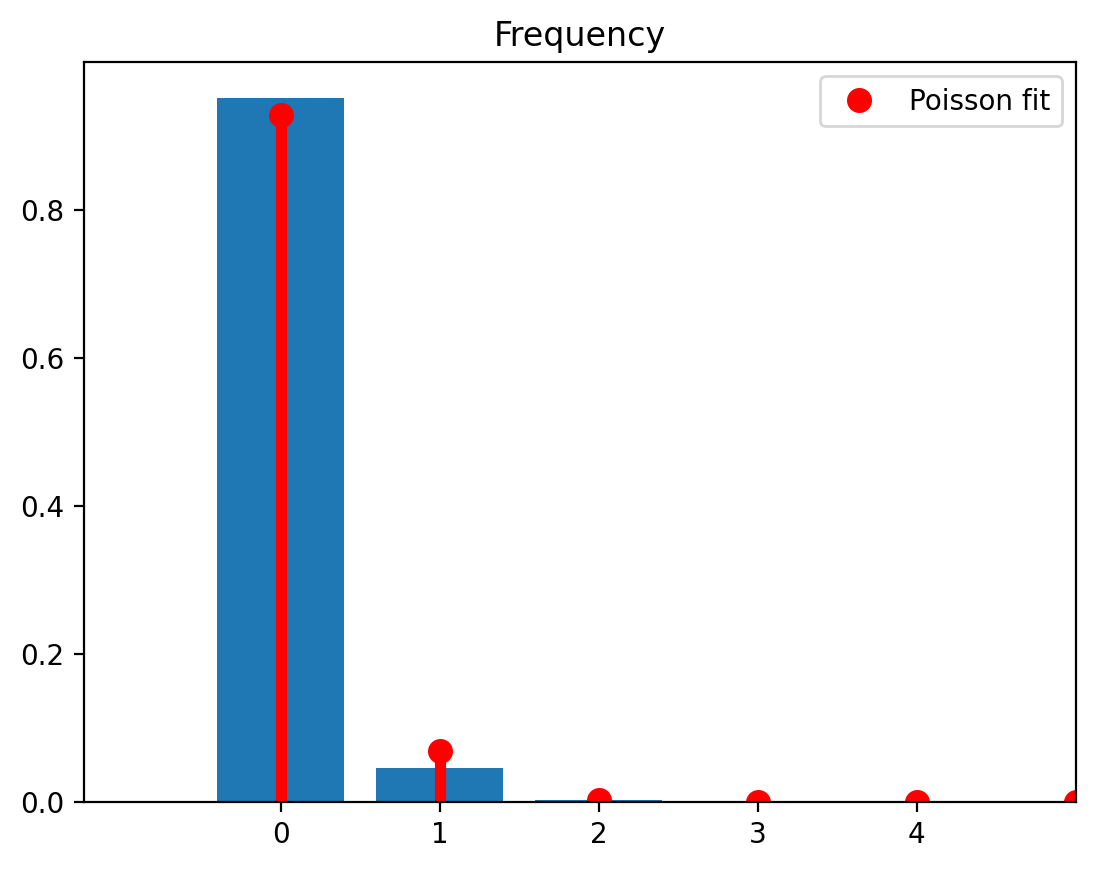

,N,Observed_frequency,Estimated_frequency
0,0,0.951805,0.928892
1,1,0.045529,0.068518
2,2,0.002536,0.002527
3,3,0.000118,0.000062
4,4,0.000006,0.000001
5,5,0.000003,0.000000
6,6,0.000001,0.000000
7,8,0.000001,0.000000
8,9,0.000000,0.000000
9,11,0.000000,0.000000


In [17]:
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', lambda x: '%.6f' % x)
claim_prop=expo_data.groupby("N").agg(Observed_frequency=('Exposure', lambda x: sum(x) / sum(expo_data['Exposure']))
                                     ).reset_index()
mean = expo_data['N'].sum() / expo_data['Exposure'].sum()
claim_prop['Estimated_frequency'] = scipy.stats.poisson.pmf(claim_prop['N'], mean)
#claim_count['N']=claim_count['N'].astype('category')
fig, ax = plt.subplots()
ax.bar(claim_prop['N'],claim_prop['Observed_frequency'])
ax.axis(xmax=5)


x = range(5)
plt.plot(claim_prop['N'], claim_prop['Estimated_frequency'], 'ro', ms=8, mec='r', label='Poisson fit')
plt.vlines(x=x, ymin=0, ymax=scipy.stats.poisson.pmf(x, mean), color='r', lw=4)
plt.xticks(x)
plt.legend()
plt.title("Frequency");
plt.show()

claim_prop

Now we visualize the data

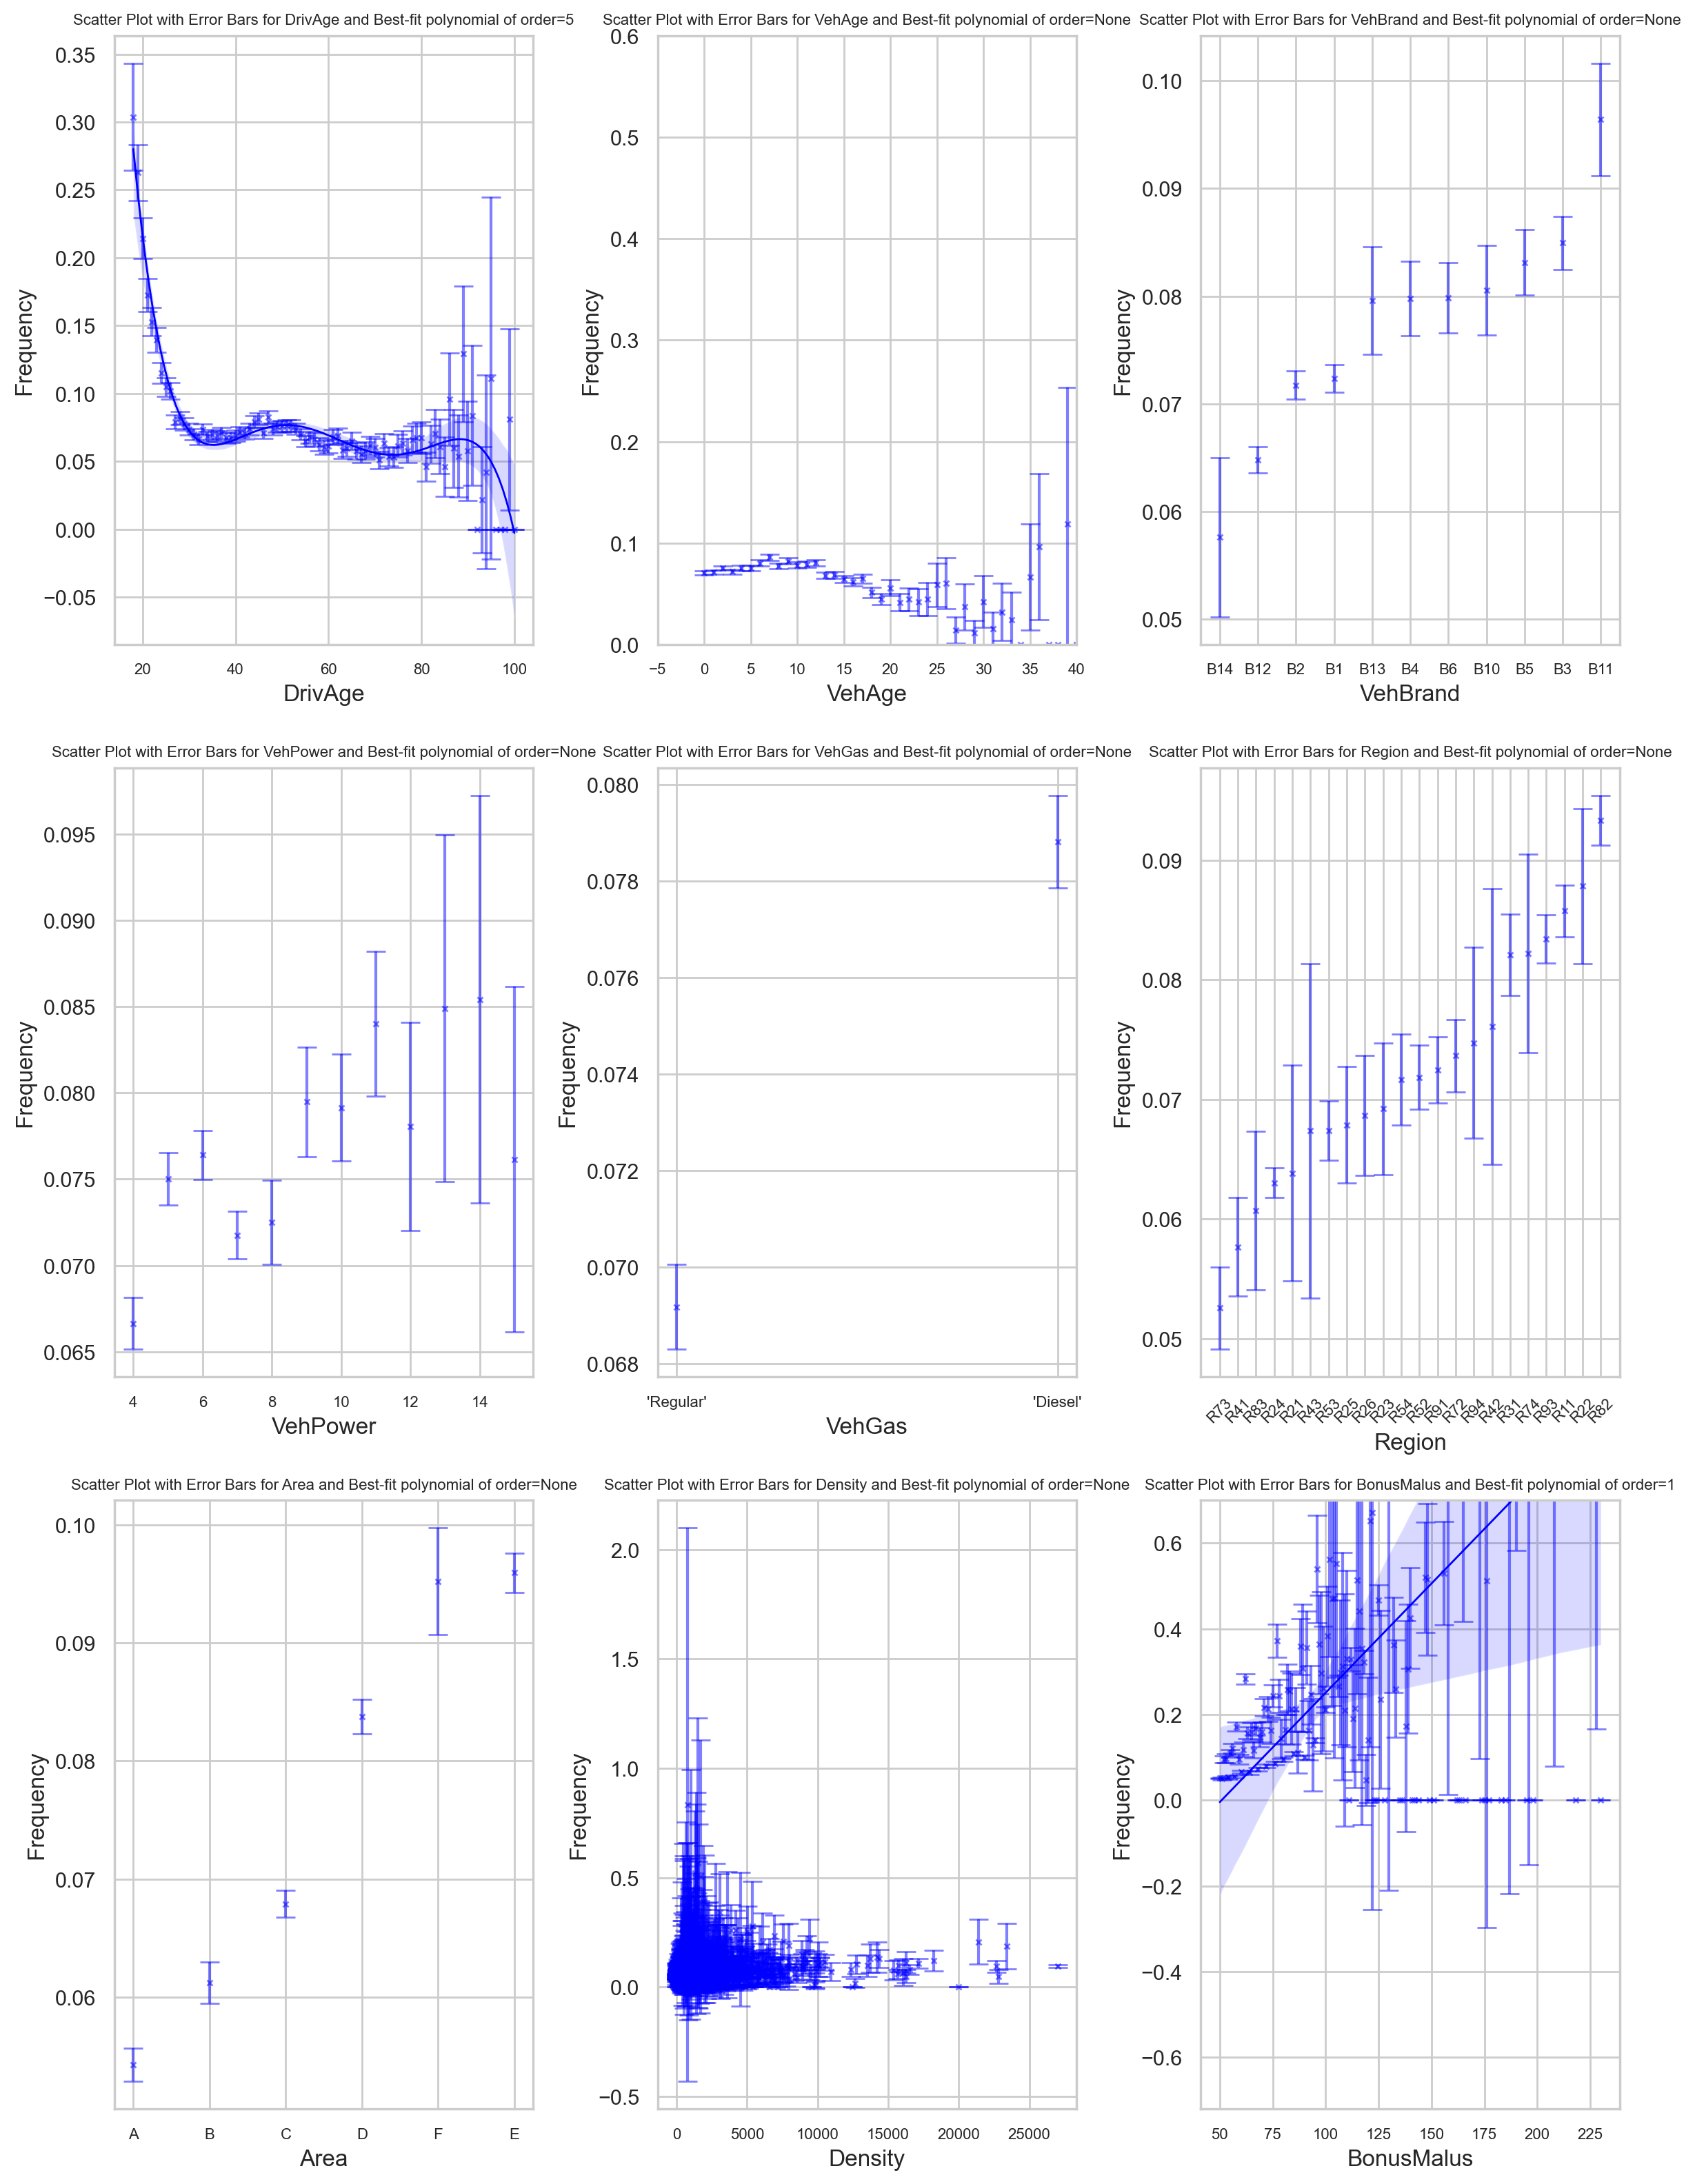

In [18]:
import seaborn as sns
sns.set(style="whitegrid")

def uni(data,variable, poly=None, order=None, xmax=None, ymin=None, ymax=None, sort=None, ax=None,rotation=None):
    var_freq = data.groupby(by=variable).agg(
        N=('N', 'sum'),
        Exposure=('Exposure', 'sum'),
        Frequency=('N', lambda x: sum(x) / sum(expo_data.loc[x.index, 'Exposure'])),
        std_err=('N', lambda x: 1.96 * np.sqrt(sum(x) / sum(expo_data.loc[x.index, 'Exposure']) / len(expo_data.loc[x.index, 'Exposure'])))
    ).reset_index()
    
    if sort:
        var_freq = var_freq.sort_values(by='Frequency')

    if ax is None:
        _, ax = plt.subplots()

    ax.errorbar(var_freq[variable], var_freq['Frequency'], yerr=var_freq['std_err'], fmt='x', capsize=5, alpha=0.5, color='blue', markersize=3)
    if poly:
        sns.regplot(x=var_freq[variable], y=var_freq['Frequency'], scatter=False, order=order,
                    line_kws={'color': 'blue', 'label': 'Polynomial best fit ', 'linewidth': 1}, ax=ax)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Scatter Plot with Error Bars for {variable} and Best-fit polynomial of order={order}',fontsize=8)

    ax.axis(ymin=ymin, ymax=ymax, xmax=xmax)

    # Change x-axis label size
    ax.tick_params(axis='x', labelsize=8,rotation=rotation)

fig, axes = plt.subplots(3, 3, figsize=(12, 16))
axes = axes.flatten()

# Call the uni function for each variable
uni(expo_data,'DrivAge', poly=True, order=5, ax=axes[0])
uni(expo_data,'VehAge', poly=False, xmax=40, ymax=0.6, ymin=0, ax=axes[1])
uni(expo_data,'VehBrand', poly=False, sort=True, ax=axes[2])
uni(expo_data,'VehPower', poly=False, sort=True, ax=axes[3])
uni(expo_data,'VehGas', poly=False, sort=True, ax=axes[4])
uni(expo_data,'Region', poly=False, sort=True, ax=axes[5],rotation=45)
uni(expo_data,'Area', poly=False, sort=True, ax=axes[6])
uni(expo_data,'Density', poly=False, sort=True, ax=axes[7])
uni(expo_data,'BonusMalus', poly=True,order=1, sort=True,ymax=0.7, ax=axes[8])

plt.tight_layout()
plt.show()


observed = False

Grouping $\textit{Density}$ and $\textit{BonusMalus}$ 


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

 


[50, 75, 100, 125, 150, 225]


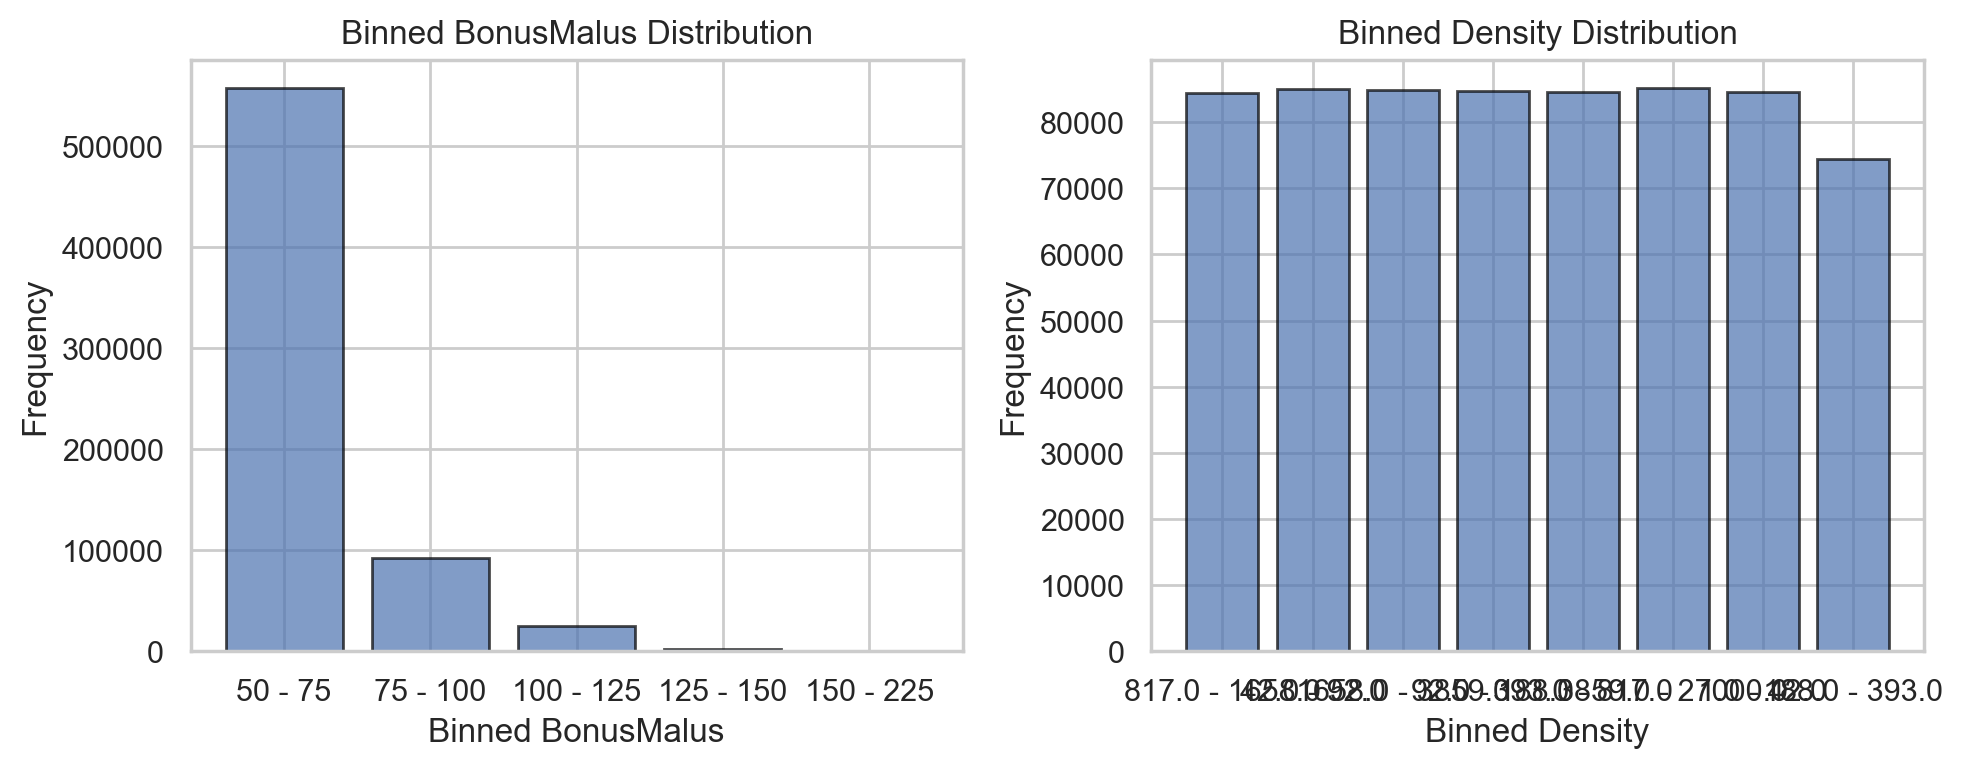

In [20]:
bin_Density = KBinsDiscretizer(n_bins=8, strategy='quantile',subsample = None,encode='ordinal')
bin_BonusMalus = KBinsDiscretizer(n_bins=3, strategy='uniform',subsample = None,encode='ordinal')
bin_Density.fit(expo_data[['Density']])
bin_BonusMalus.fit(expo_data[['BonusMalus']])

# Get bin edges from the fitted KBinsDiscretizer
bin_edges_BonusMalus = [50,75,100,125,150,225]
bin_edges_Density = bin_Density.bin_edges_[0]
print(bin_edges_BonusMalus)

# Create intervals from bin edges
intervals_BonusMalus = [f"{round(bin_edges_BonusMalus[i], 2)} - {round(bin_edges_BonusMalus[i + 1], 2)}" for i in range(len(bin_edges_BonusMalus) - 1)]
intervals_Density = [f"{round(bin_edges_Density[i], 2)} - {round(bin_edges_Density[i + 1], 2)}" for i in range(len(bin_edges_Density) - 1)]

# Assign bin labels to the DataFrame
binned_BonusMalus = pd.cut(expo_data['BonusMalus'], bins=bin_edges_BonusMalus, labels=intervals_BonusMalus, include_lowest=True, right=False)
binned_Density = pd.cut(expo_data['Density'], bins=bin_edges_Density, labels=intervals_Density, include_lowest=True, right=False)
#expo_data['binned_BonusMalus'] = expo_data['binned_BonusMalus'].dropna()
#expo_data['binned_Density'] = expo_data['binned_Density'].dropna() 
# Convert numeric bin labels to strings
BonusMalus_labels = [str(label) for label in binned_BonusMalus.dropna().unique()]
Density_labels = [str(label) for label in binned_Density.dropna().unique()]



# Create bar charts for binned BonusMalus and Density
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(BonusMalus_labels, binned_BonusMalus.value_counts(sort=False).sort_index().dropna(), edgecolor='black', alpha=0.7)
plt.xlabel('Binned BonusMalus')
plt.ylabel('Frequency')
plt.title('Binned BonusMalus Distribution')

plt.subplot(1, 2, 2)
plt.bar(Density_labels, binned_Density.value_counts(sort=False).sort_index().dropna(), edgecolor='black', alpha=0.7)
plt.xlabel('Binned Density')
plt.ylabel('Frequency')
plt.title('Binned Density Distribution')

plt.tight_layout()
plt.show()

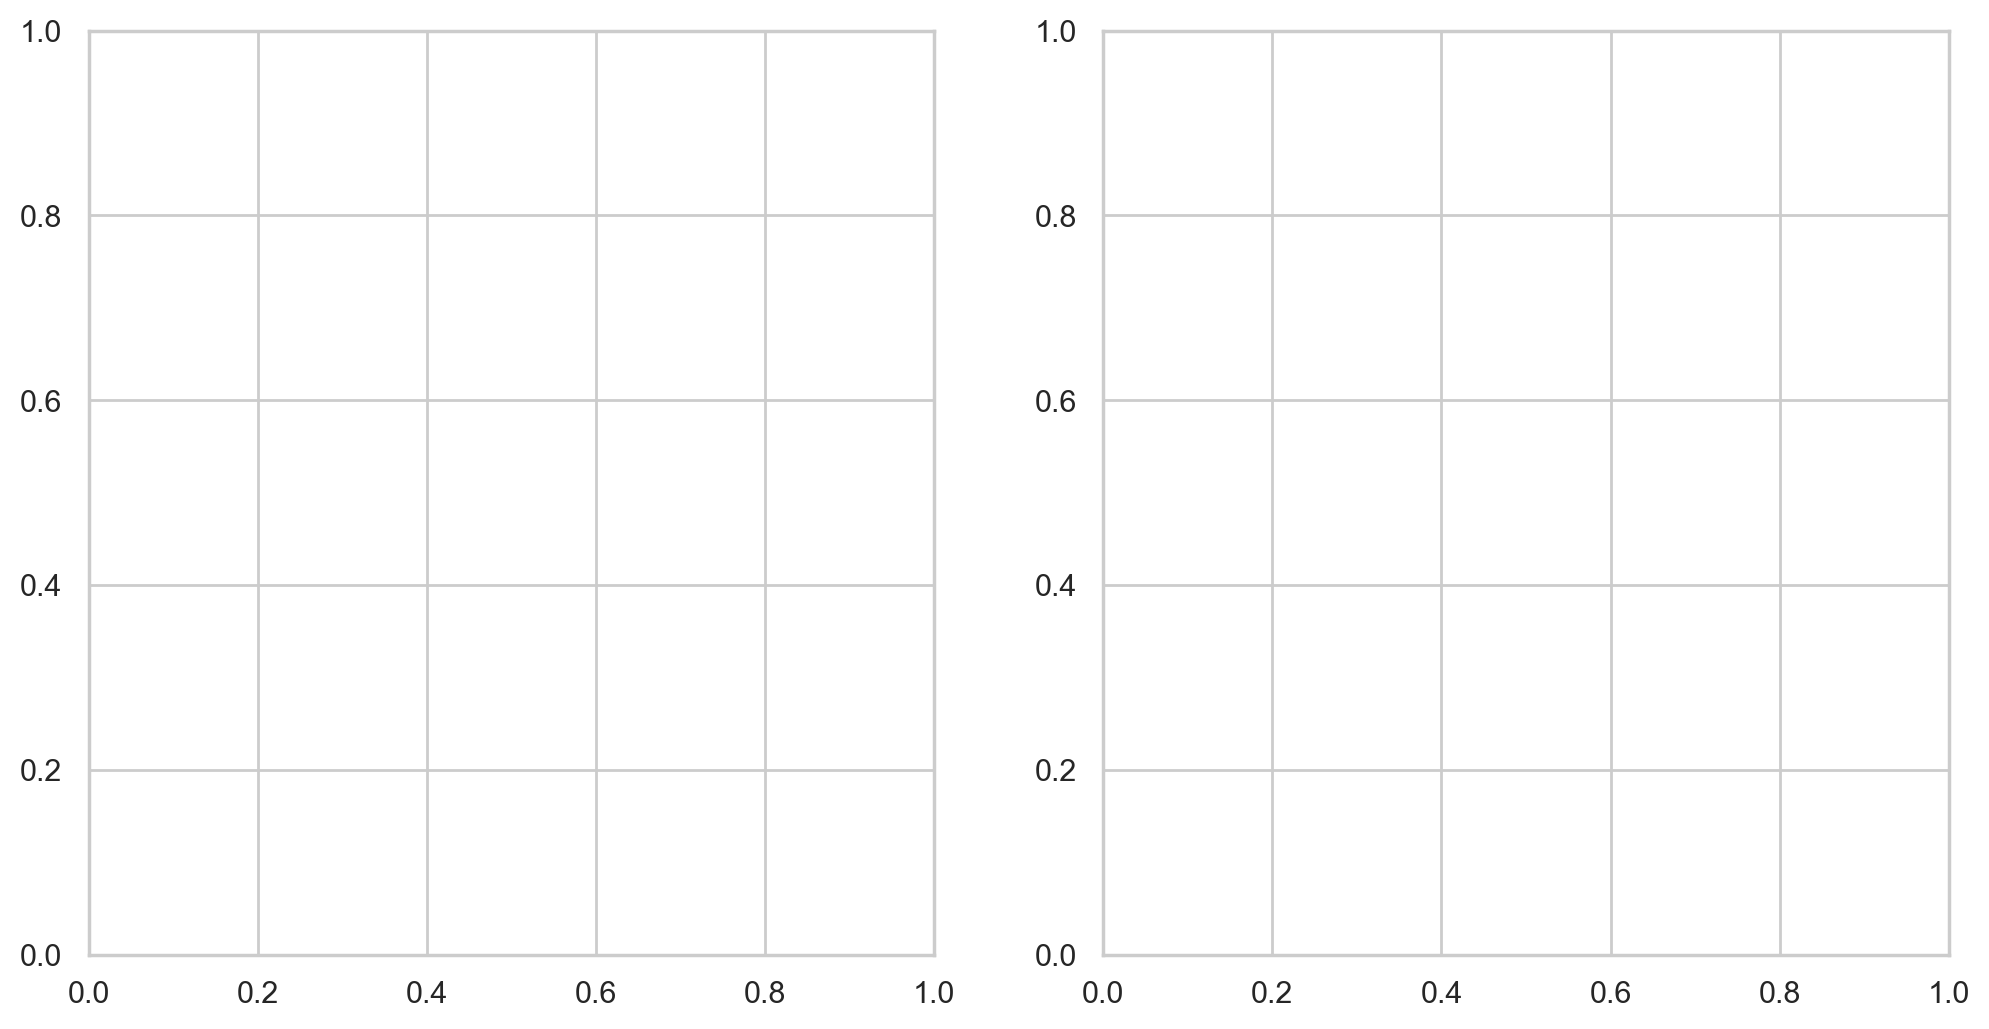

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

#uni(expo_data,'binned_BonusMalus', ax=axes[0])
#uni(expo_data,'binned_Density', ax=axes[1],rotation=45)
#plt.tight_layout()
#plt.show()


There is a positive association between BonusMalus group and claim frequency, such that customers with higher BonusMalus values have a higher claims frequency. A similar effect is seen for the Density variable, which seems natural.

Checking the type of each variable

In [22]:
expo_data.dtypes

IDpol            int32
Exposure       float64
Area          category
VehPower         int64
VehAge           int64
DrivAge          int64
BonusMalus       int64
VehBrand      category
VehGas          object
Density          int64
Region        category
N                int32
dtype: object

Changing type of variables

In [23]:
expo_data = expo_data.astype({'VehGas':'category','IDpol':'category'})
VehPower_val = pd.DataFrame(expo_data['VehPower'].unique(), columns=['VehPower'])
VehPower_val = VehPower_val.sort_values(by='VehPower')
VehPower_val = VehPower_val['VehPower']
VehPowerdtype = pd.CategoricalDtype(categories=VehPower_val,ordered=True)
expo_data['VehPower'] = expo_data['VehPower'].astype(VehPowerdtype)  
expo_data.dtypes
#Saving expo_data
expo_data.to_csv('expo_data.csv', index=False)
expo_data
    

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,N
0,1,0.100000,D,5,0,55,50,B12,'Regular',1217,R82,0
1,3,0.770000,D,5,0,55,50,B12,'Regular',1217,R82,0
2,5,0.750000,B,6,2,52,50,B12,'Diesel',54,R22,0
3,10,0.090000,B,7,0,46,50,B12,'Diesel',76,R72,0
4,11,0.840000,B,7,0,46,50,B12,'Diesel',76,R72,0
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0.002740,E,4,0,54,50,B12,'Regular',3317,R93,0
678009,6114327,0.002740,E,4,0,41,95,B12,'Regular',9850,R11,0
678010,6114328,0.002740,D,6,2,45,50,B12,'Diesel',1323,R82,0
678011,6114329,0.002740,B,4,0,60,50,B12,'Regular',95,R26,0


# Preprocessing 

<span style="color:red;"> To do: Why it is necessary to preprocess in a pipeline when performing Cross-validation? <span>


We will consider the following preprocessors: 
1) Standardize all numerical variables, one-hot encode categorical.
2) Standardize numerical variables,group Density and Bonus-Malus, one-hot encode categorical.

Note that when the categorical variables are one-hot encoded, the reference level is chosen to be the first value of the variable. Reference level chosen to avoid unneccesary collinearity between one-hot encoded variables and thereby stability in the estimated coefficients. There may still be collinearity between the remainder variables, and therefore a regularization parameter can be introduced to reduce unstability in estimated coeffients. The intercept term $\beta_0$ is included by default and can be extracted from the regressor as is shown below:

In [39]:
preprocessor1 = ColumnTransformer([
      ("onehot_cat",OneHotEncoder(sparse_output=False, handle_unknown="ignore",categories='auto',drop='first'),["Area","VehPower","VehBrand","VehGas","Region"]),
      ( "standardize_num",StandardScaler(),["VehAge","DrivAge","BonusMalus","Density"])
    ],remainder="drop")


preprocessor2 = ColumnTransformer([
        ("onehot_cat",OneHotEncoder(sparse_output=False, handle_unknown="ignore"),["Area","VehPower","VehBrand","VehGas","Region"]),
        ("standardize_num",StandardScaler(),["VehAge","DrivAge"]),
        ("bin_Density",KBinsDiscretizer(n_bins=8,strategy='quantile'),["Density"]),
        ("bin_BonusMalus",KBinsDiscretizer(n_bins=4,strategy='uniform'),["BonusMalus"]),
    ],remainder="drop")



# Baseline model

 <span style="color:red;"> To do: Assume number of claims generated by homogenous Poisson process with intensity theta depending on covariates. Simplest model is where no covariates. i.e. policyholder have same intensity. Show that $\hat{\tilde{N}}_i$ is in fact the MLE </span>

We consider a baseline model which will serve as a benchmark when comparing the various frequency models. We consider the simplest possible model, namely where the estimated frequency is set to the portfolio wide frequency, i.e. $\hat{\tilde{N}}_i=\dfrac{\sum_i N_i}{\sum_i \text{Exposure}_i}.$
This can be fitted using the PoissonRegressor() with $y_i=\tilde{n_i}$,$w_{i}=\text{Exposure}_i$ and without covariates.  


In [25]:
preprocessor_baseline = ColumnTransformer([
        ],remainder="drop")

In [26]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_poisson_deviance

In [27]:
expo_data['Frequency'] = expo_data["N"]/expo_data["Exposure"]

In [28]:
train, test = train_test_split(expo_data,test_size=0.2,random_state=0)
baseline_fm = Pipeline(
    [
        ("preprocessor_baseline",preprocessor_baseline),
        ("regressor", DummyRegressor(strategy="mean"))
    ]
).fit(train,train["Frequency"],regressor__sample_weight=train["Exposure"])
ypred_baseline = baseline_fm.predict(test)

In [29]:
def poisson_deviance(obs,est,weight=1):
 return weight*2*(special.xlogy(obs,obs/est)-(obs-est))

The mean_poisson_deviance() function with sample_weight = $\text{Exposure}_i$ outputs the exposure weighted average of the individual deviances, as is illustrated below.

In [30]:
np.sum(poisson_deviance(test["Frequency"],ypred_baseline,weight=test["Exposure"]))/np.sum(test["Exposure"])

0.4784683005400969

In [31]:
dev_baseline_fm=mean_poisson_deviance(test['Frequency'],ypred_baseline,sample_weight=test['Exposure'])
dev_baseline_fm

0.4784683005400969

# Poisson GLM 

## A comment on scikit-learn's PoissonRegressor()

Before commencing on the model fitting, a relevant question to be asked is: 

$\textbf{Can an offset be incorporated in the model formulation in scikit-learn?}$

The answer to this, as far as I have understood, is $\textbf{yes}$ but not in the traditional sense.

In https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html#sphx-glr-auto-examples-linear-model-plot-poisson-regression-non-normal-loss-py, the author fits the PoissonRegressor() function to the individual level frequencies, $\tilde{N_i}:=\dfrac{N_i}{\text{Exposure}_i}$ and specifies sample weights equal to the Exposure, i.e. $w_i:={\text{Exposure}_i}$. From the source code (e.g.scikit-learn/sklearn/linear_model/_glm and/or https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models) , the minimization problem of e.g. PoissonRegresssor() is: 

$$ \min_{\beta} \dfrac{1}{2*\sum_{i} w_i} \sum_i w_i D(y_i,h(X_i^T \beta)) + \dfrac{1}{2}\alpha ||\beta||_2^2,$$

where $X_i$ is the design-matrix, $ D(y_i,h(X_i^T \beta)$ is the deviance function of the corresponding Exponential Dispersion Model, $h(.)$ is the inverse-link function, $w_i$ are sample weights and $\alpha$ is a reqularization parameter. 

$ \textbf{Result}: $




$ 
\text{Let} \quad N_i \stackrel{\text{iid}}{\sim} \text{Poi}(\lambda_i), \quad \log(\lambda_i) = X_i^T \beta + \log(w_i$).
Let $n_i$ be realizations of $N_i$ and let $ l_{\beta} (n_1,n_2,...)$ denote the log-likelihood function under this model. The following holds: 

$$l_{\beta}(n_1,n_2,...) \propto \dfrac{1}{2*\sum_{i} w_i} \sum_i w_i D(\tilde{n}_i,e^{(X_i^T \beta)}),$$ where $\tilde{n}_i:=\dfrac{n_i}{w_i}$ is the observed frequencies.

$ \textbf{Proof}: $

Note first that:
$$l_{\beta}(n_1,n_2,...)=\sum_i \log P(N_i=n_i)=\sum_i [n_i \log \lambda_i-\lambda_i-\log n_i!] \propto \sum_i \left[n_i(X_i^T \beta) -e^{X_i^T \beta} w_i\right]=\sum_i w_i\left[\tilde{n_i}(X_i^T \beta) -e^{X_i^T \beta} \right].$$

The result follows by observing that:
$$\dfrac{1}{2*\sum_{i} w_i} \sum_i w_i D(\tilde{n}_i,e^{X_i^T \beta} ) \propto \sum_i w_i D(\tilde{n}_i,e^{X_i^T \beta} ) = -2\sum_i w_i (\tilde{n}_i(X_i^T \beta)-\tilde{n}_i \log \tilde{n}_i-e^{X_i^T \beta}+\tilde{n}_i) \propto \sum_i w_i\left[\tilde{n_i}(X_i^T \beta) -e^{X_i^T \beta} \right]$$, where I have used that under the Poisson EDM, the deviance is given by $D(y,\hat{y})=2 \left( y\log\dfrac{ y}{\hat{y}}-y+\hat{y} \right). \square $

<span style="color:blue;"> In other words: Fitting the PoissonRegressor() to the individual level frequencies $\tilde{N_i}$ with sample weights $w_i:={\text{Exposure}_i}$ and $h(X_i^T \beta)=e^{(X_i^T \beta)}$ corresponds to fitting a Poisson log-link regression model with offset equal to $\log(\text{Exposure}_i)$</span>


## Model fitting

Now we fit a Poisson GLM model with all covariates and with a regularization parameter through the Pipeline functionality.

In [67]:
from sklearn.linear_model import PoissonRegressor
poissonglm_fm = Pipeline(
    [
        ("preprocessor",preprocessor1),
        ("regressor", PoissonRegressor(alpha=0.008, solver="newton-cholesky"))
    ]
)
poissonglm_fm.fit(train,train["Frequency"],regressor__sample_weight=train["Exposure"])
ypred_poissonglm = poissonglm_fm .predict(test)
dev_poissonglm_fm=mean_poisson_deviance(test['Frequency'],ypred_poissonglm, sample_weight=test['Exposure'] )
print(" Deviance ",dev_poissonglm_fm)
print(" Relative decrease in deviance compared to baseline model ",1-dev_poissonglm_fm/dev_baseline_fm)

 Deviance  0.460494591021713
 Relative decrease in deviance compared to baseline model  0.03756509992008905


We can try to improve the model fit by tuning the hyper-parameters of the Poissonregressor() model. 

## Hyper-parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid_poisson = {
    "regressor__alpha": np.linspace(0,0.1,50),
}
search = GridSearchCV(poissonglm_fm, param_grid_poisson, n_jobs=-1,scoring = "neg_mean_poisson_deviance")
search.fit(train,train["Frequency"],regressor__sample_weight=train["Exposure"])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

## Model summary including bootstrap-based confidence intervals

I now define a function which takes a pipeline as input with a parametric regression model and outputs estimated coefficients and 95% bootstrap confidence intervals

In [267]:
def boot_for_parametric_models(B,data,pipe,weight=False):
    coefficient_matrix = coefficient_matrix = np.empty((len(pipe.named_steps["regressor"].coef_), 0))
    # Fit the pipeline to training data
    if weight:
       pipe.fit(data,data["Frequency"],regressor__sample_weight=data["Exposure"])
    else: 
       pipe.fit(data,data["Frequency"],regressor__sample_weight=1)
     # Fit the pipeline to the bootstrapped data and append columnwise to coefficient_matrix 
    for _ in range(B):
        bootstrap_sample = data.sample(n=len(data), replace=True)
        if weight:
           sample_weight = bootstrap_sample["Exposure"]
        else:
           sample_weight = 1
        pipe.fit(bootstrap_sample,bootstrap_sample["Frequency"],regressor__sample_weight=sample_weight)
        regressor = pipe.named_steps["regressor"]
        coefficients = np.exp(regressor.coef_)
        coefficient_matrix = pd.DataFrame(np.hstack((coefficient_matrix, coefficients.reshape(-1, 1))))
    # Calculate lower and upper quantile based on the bootstrap empirical distribution of each indisidual parameter estimate
    lower = coefficient_matrix.quantile(0.025,axis='columns')
    upper = coefficient_matrix.quantile(0.975,axis='columns')
    

    # Get the estimated coefficients and variable labels
    regressor = pipe.named_steps["regressor"]
    coefficients = np.exp(regressor.coef_)

    # Get the column names after preprocessing
    column_names = preprocessor1.get_feature_names_out(train.columns)
    #print(column_names)
    label = np.array([name.split("_")[-1] for name in column_names]) #Exclude preprocess label
    variable = np.array([name.split("_")[3] for name in column_names]) #Exclude preprocess label

    # Display coefficients along with variable labels
    coefficients_with_labels = list(zip(variable,label, coefficients,lower,upper))
    coefficients_with_labels.append(["Intercept","Intercept",np.exp(regressor.intercept_)])
    coefficients_with_labels = pd.DataFrame(coefficients_with_labels,columns =  ["Variable","Label",r"$e^{\hat{\beta}}$","Lower_boot","Upper_boot"])

    return  coefficients_with_labels



        
    

For example, we can view the estimated coefficients $e^{\beta}$ along with the lower and upper bootstrap-based confidence intervals for a pipeline with the Poisson regressor

In [276]:
poisson_est_coef = boot_for_parametric_models(B=100,data=train,pipe=poissonglm_fm,weight=True)
poisson_est_coef 

,Variable,Label,$e^{\hat{\beta}}$,Lower_boot,Upper_boot
0,Area,B,0.972575,0.956447,0.992363
1,Area,C,1.039336,0.987267,1.027501
2,Area,D,1.112903,1.083148,1.132702
3,Area,E,1.097533,1.100744,1.148235
4,Area,F,0.989829,0.983319,0.998423
5,VehPower,5,0.975702,0.968920,1.005496
6,VehPower,6,1.031999,1.001503,1.033750
7,VehPower,7,1.005075,0.974042,1.013062
8,VehPower,8,1.017616,0.994647,1.027962
9,VehPower,9,1.020871,1.013324,1.053262


We can plot the estimated coefficients as follows:

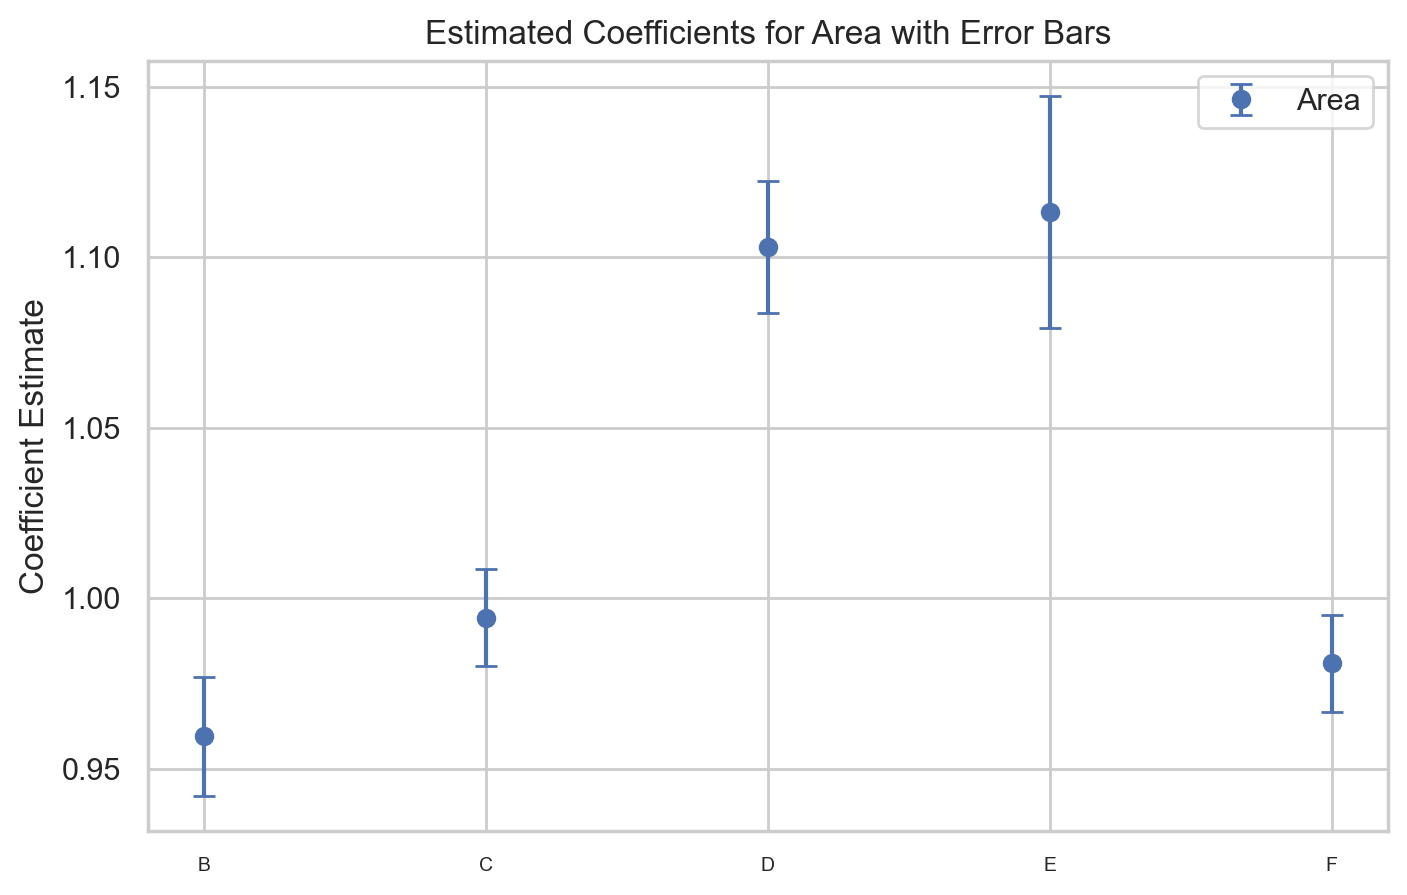

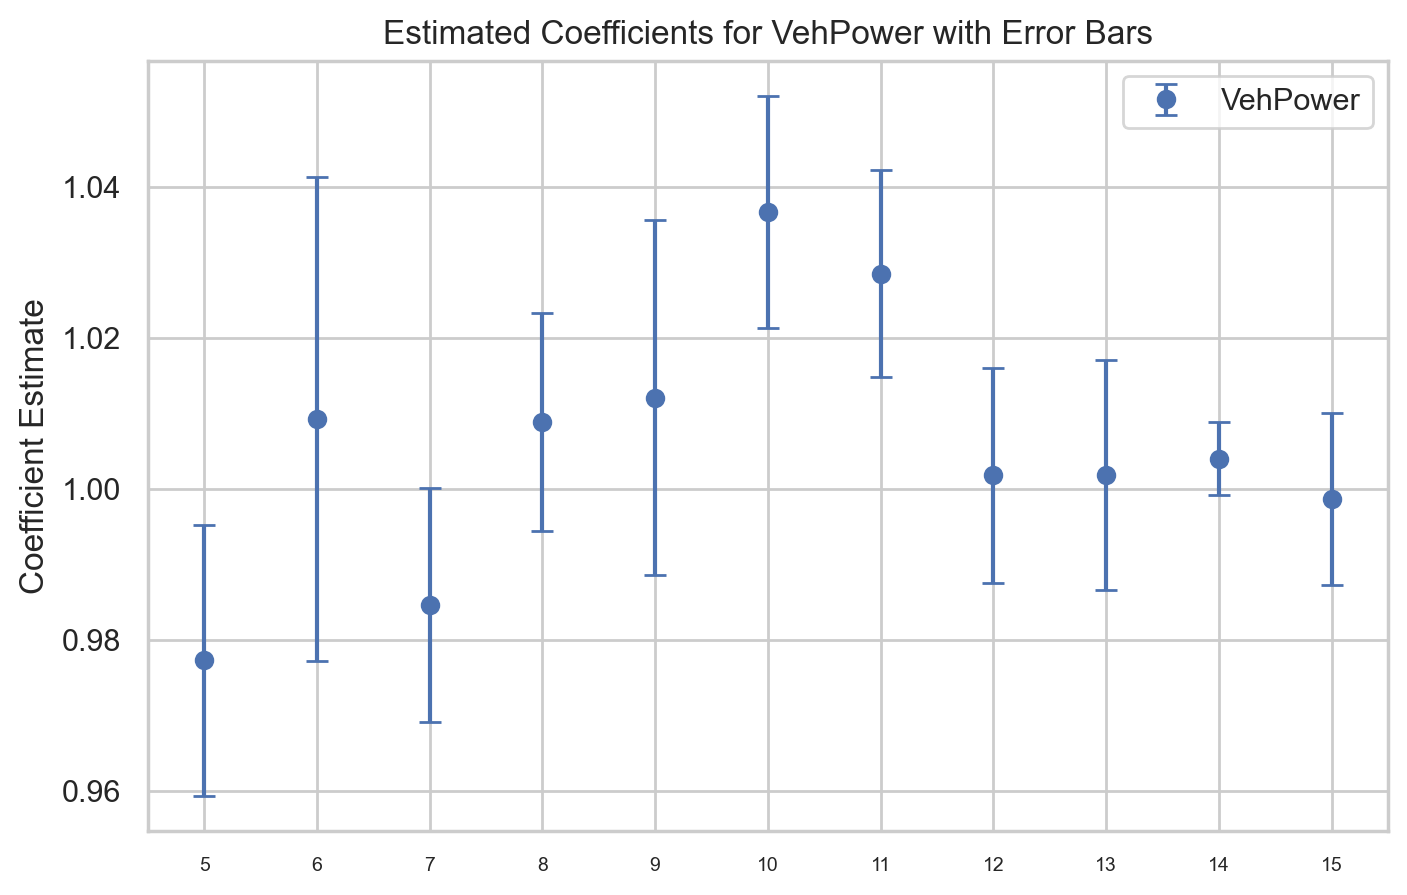

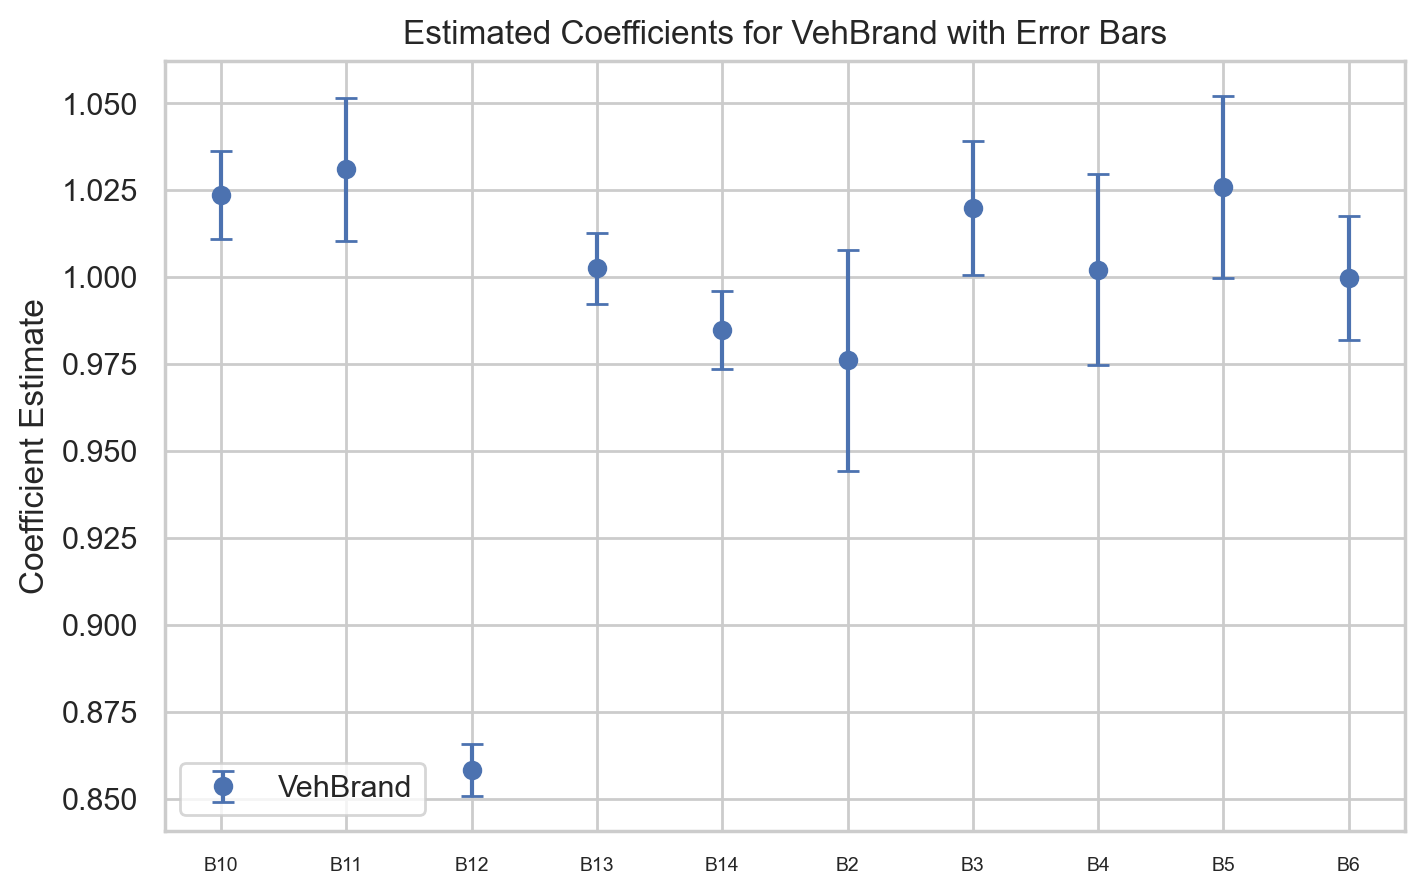

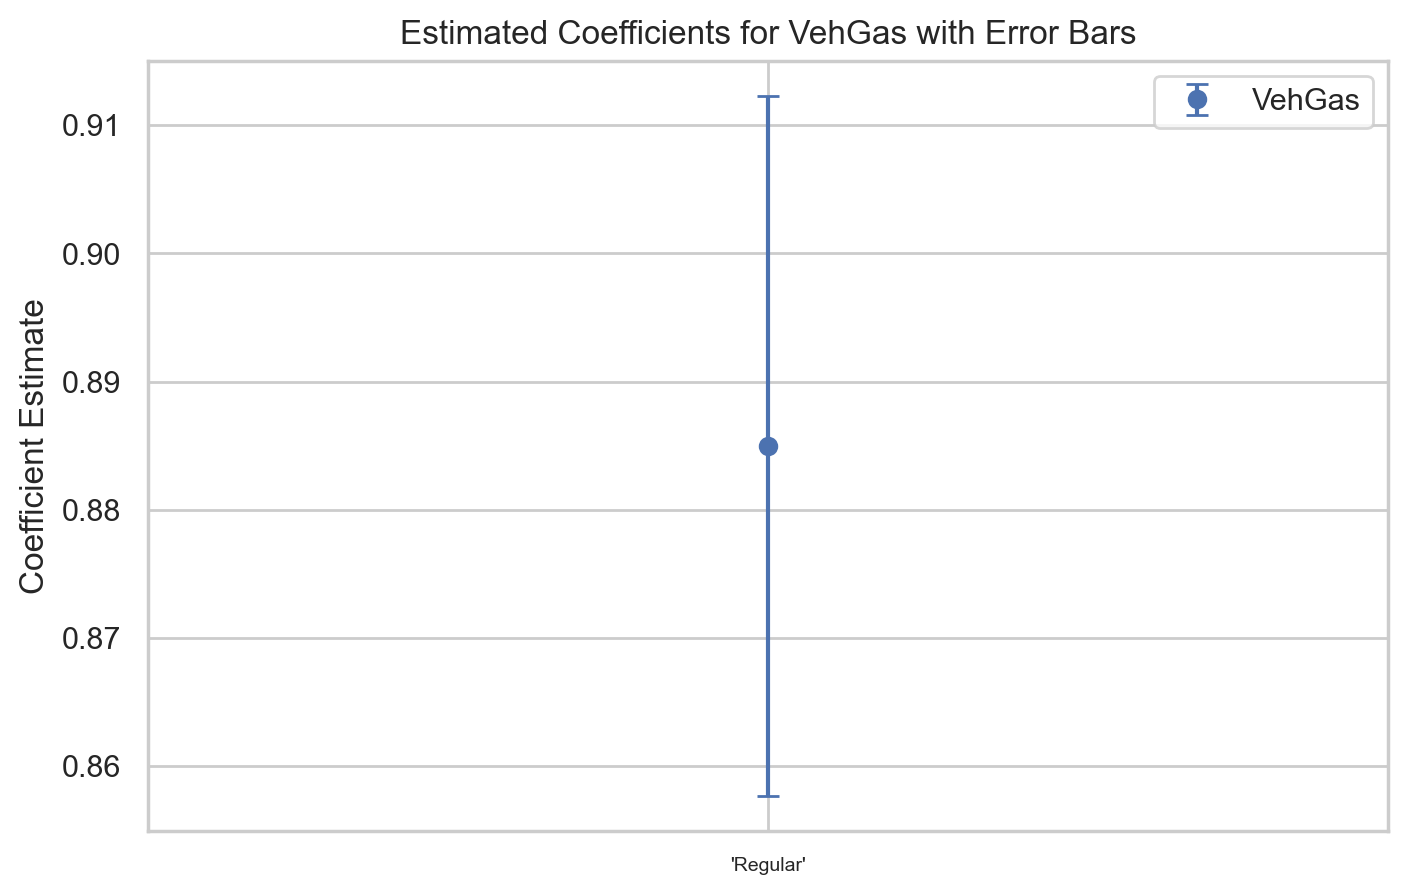

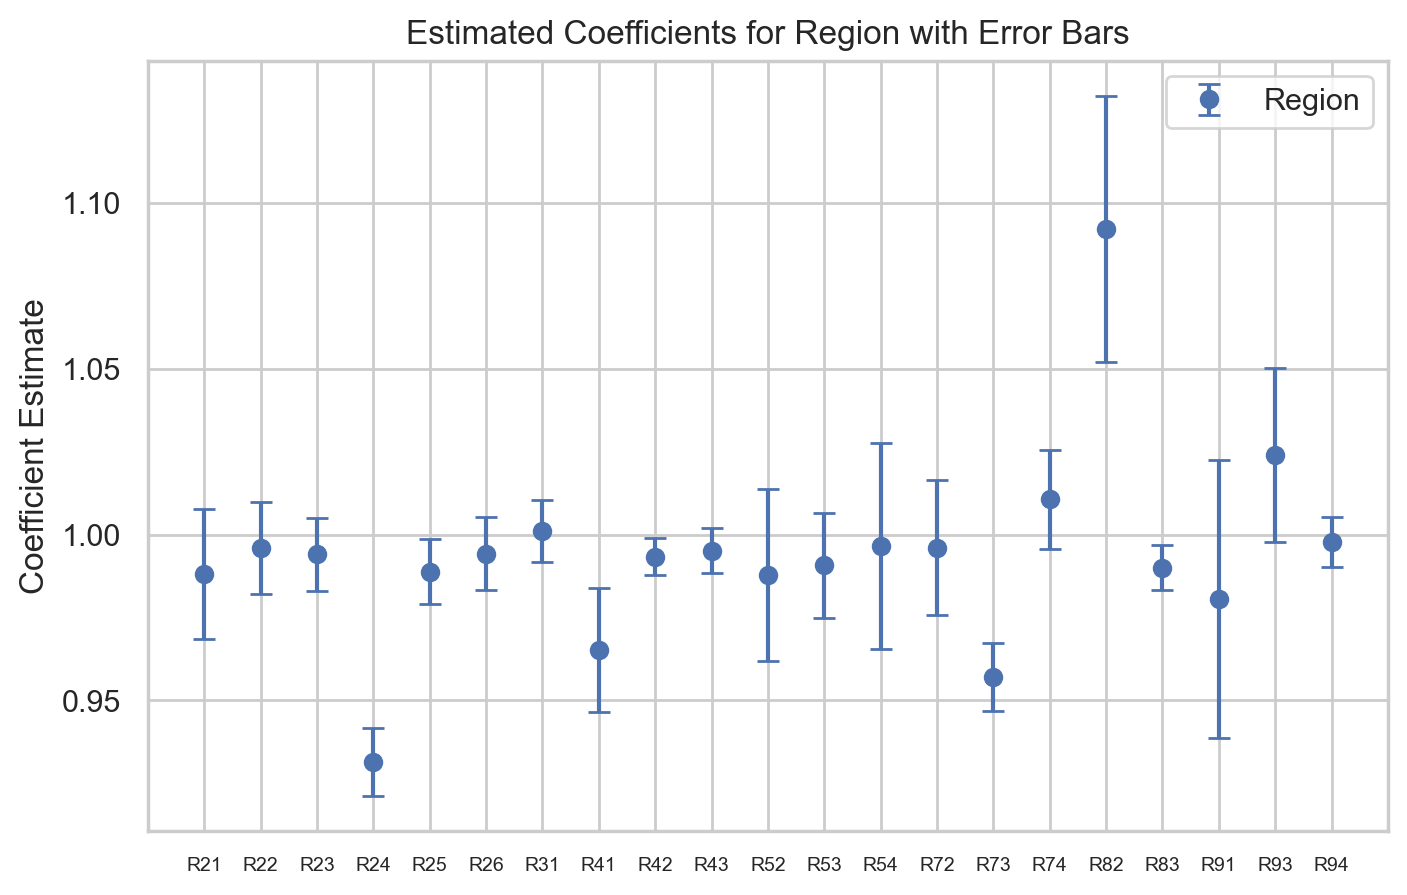

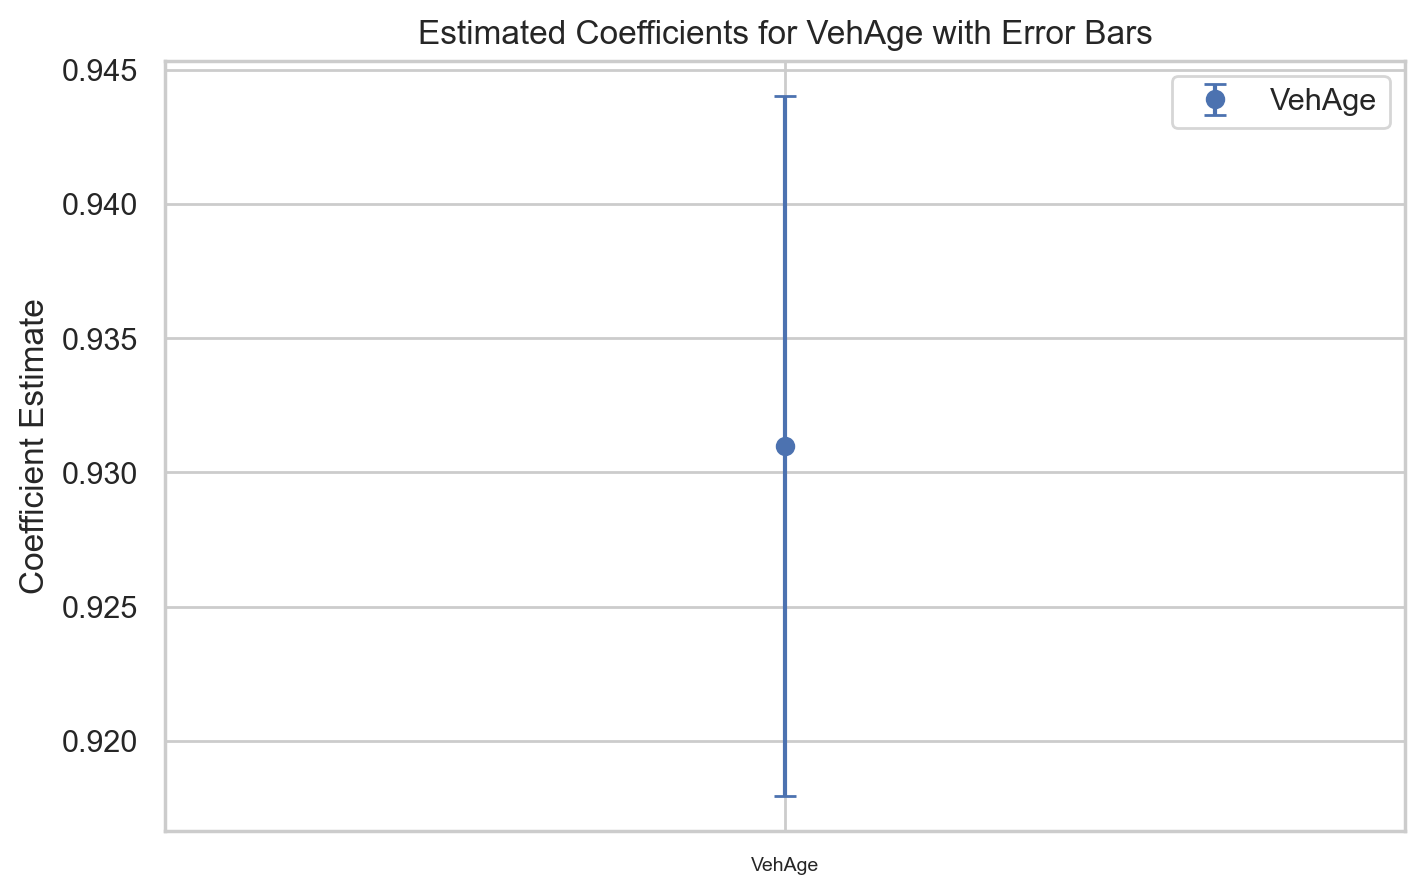

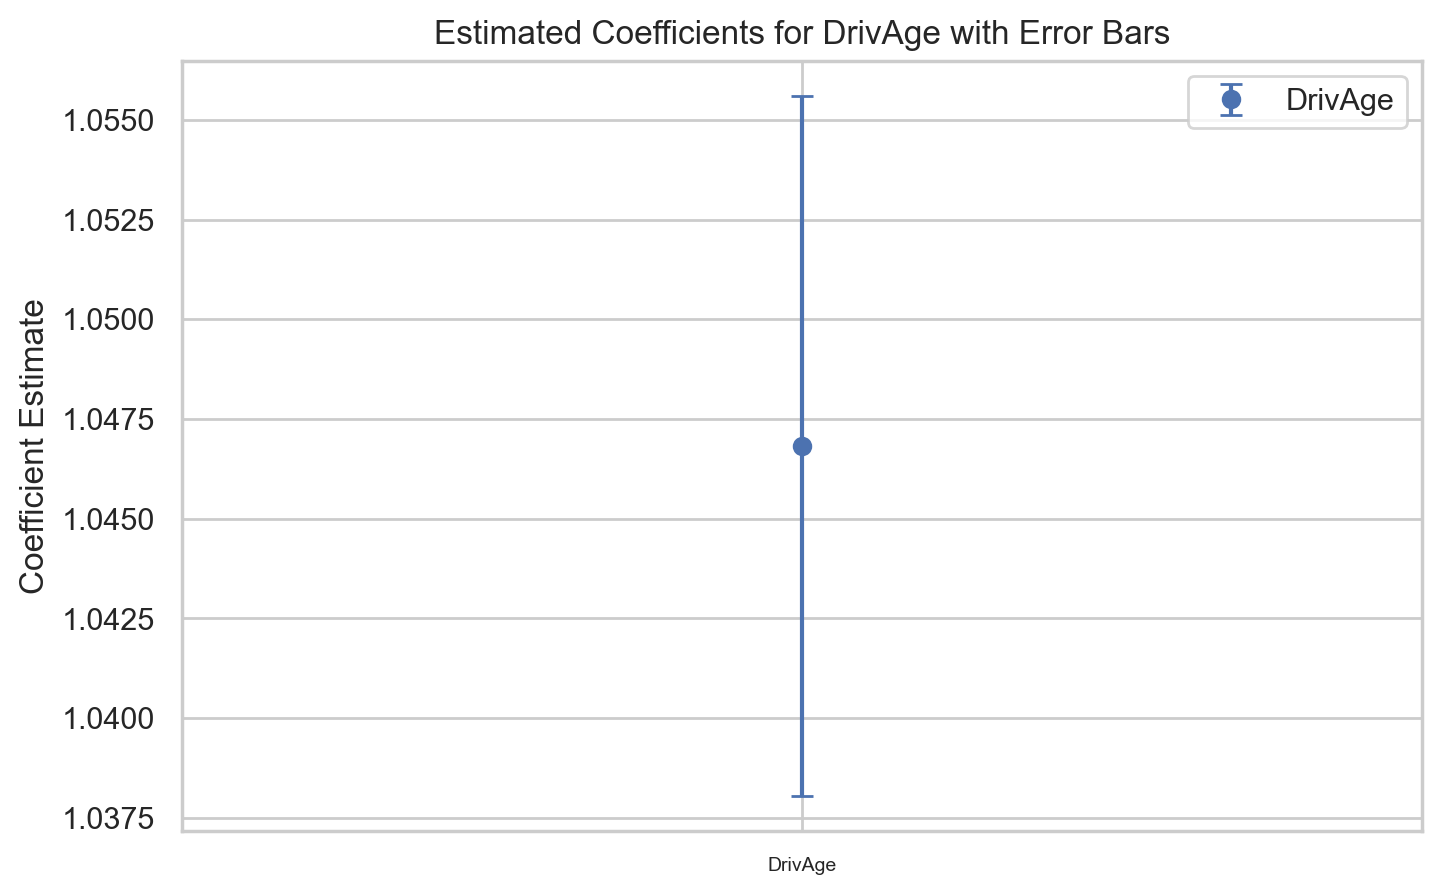

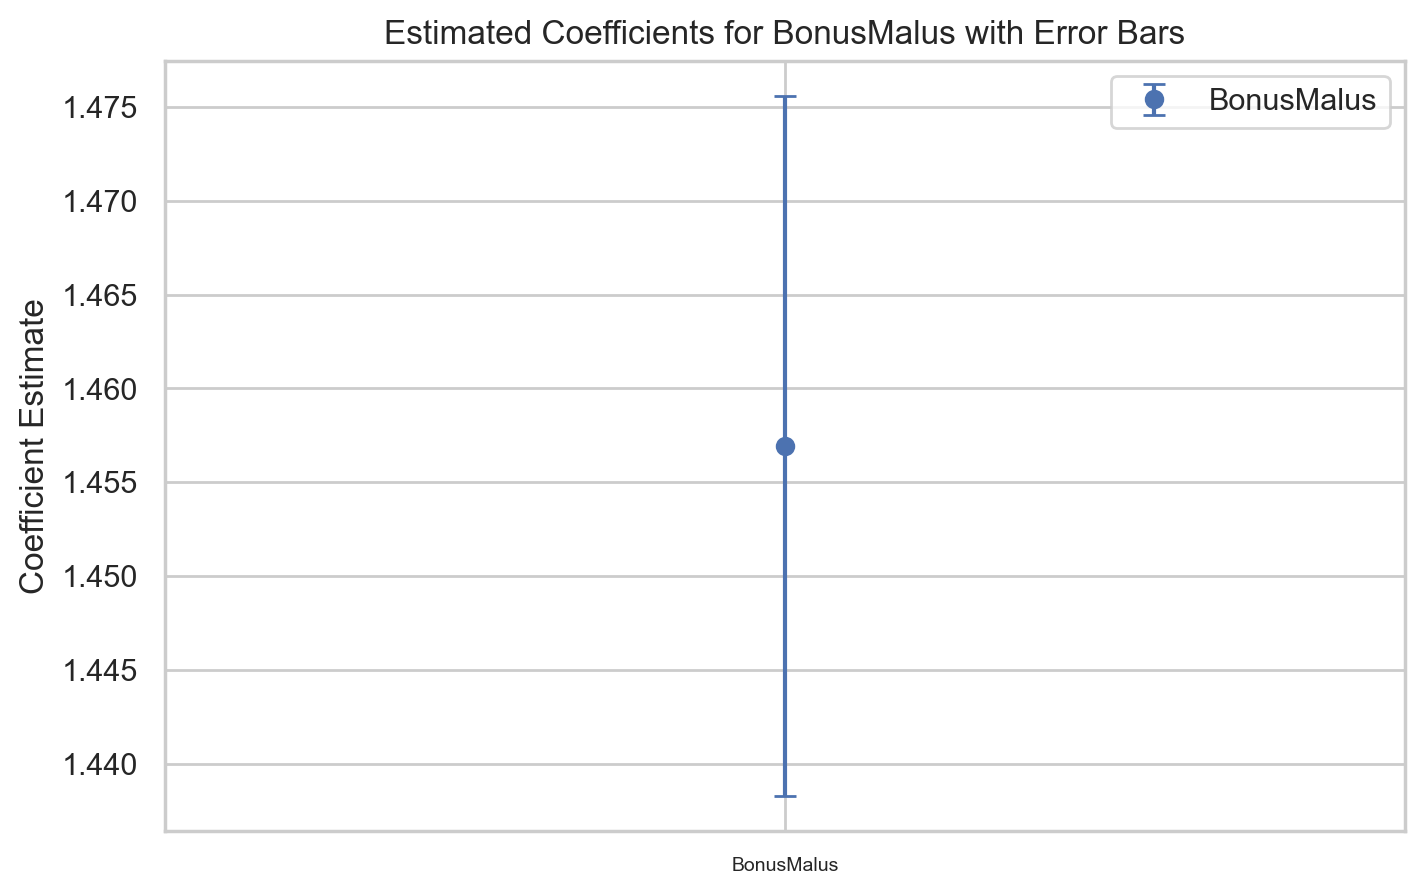

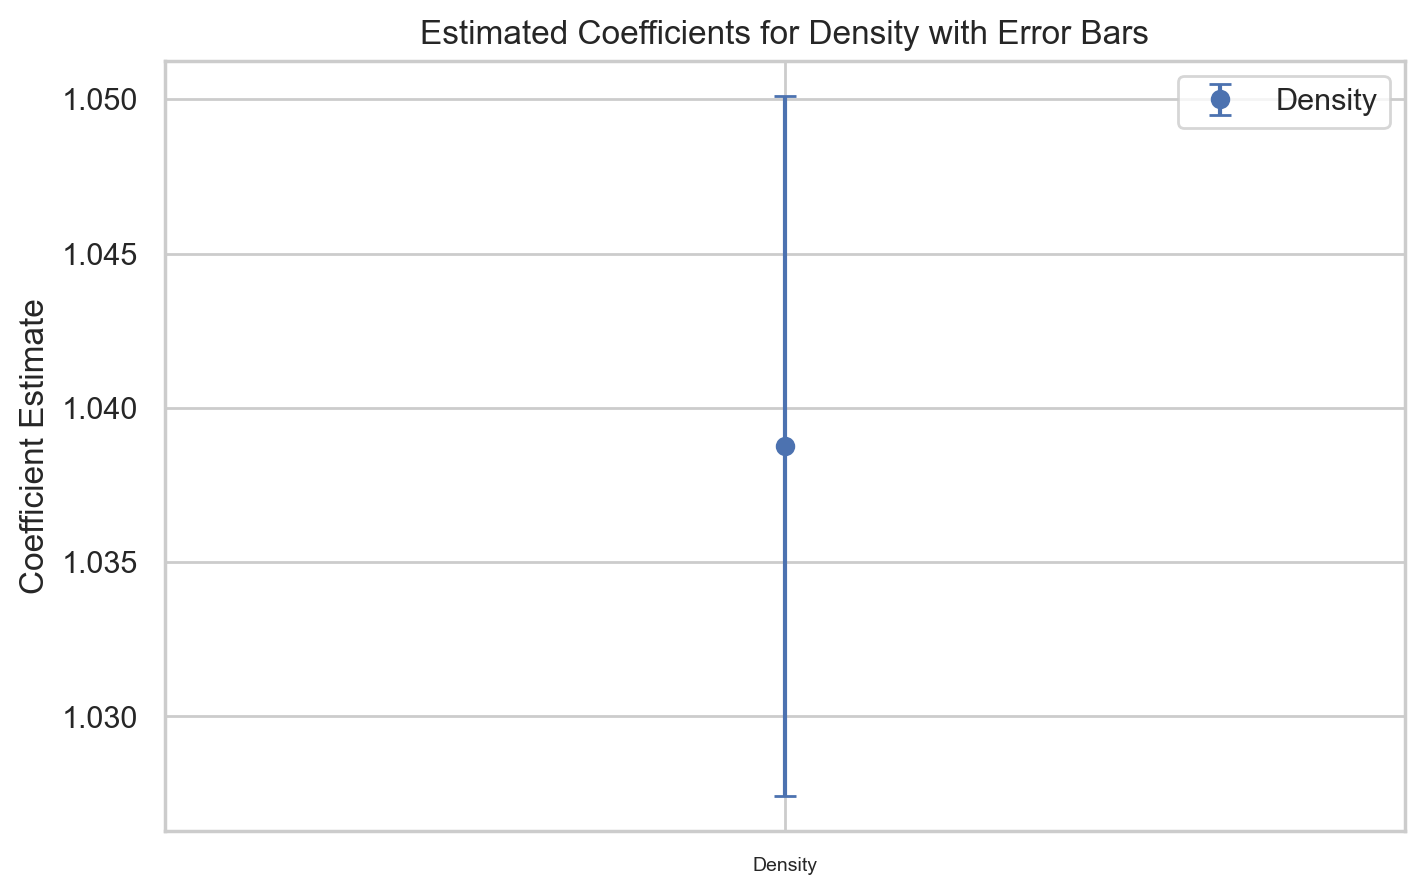

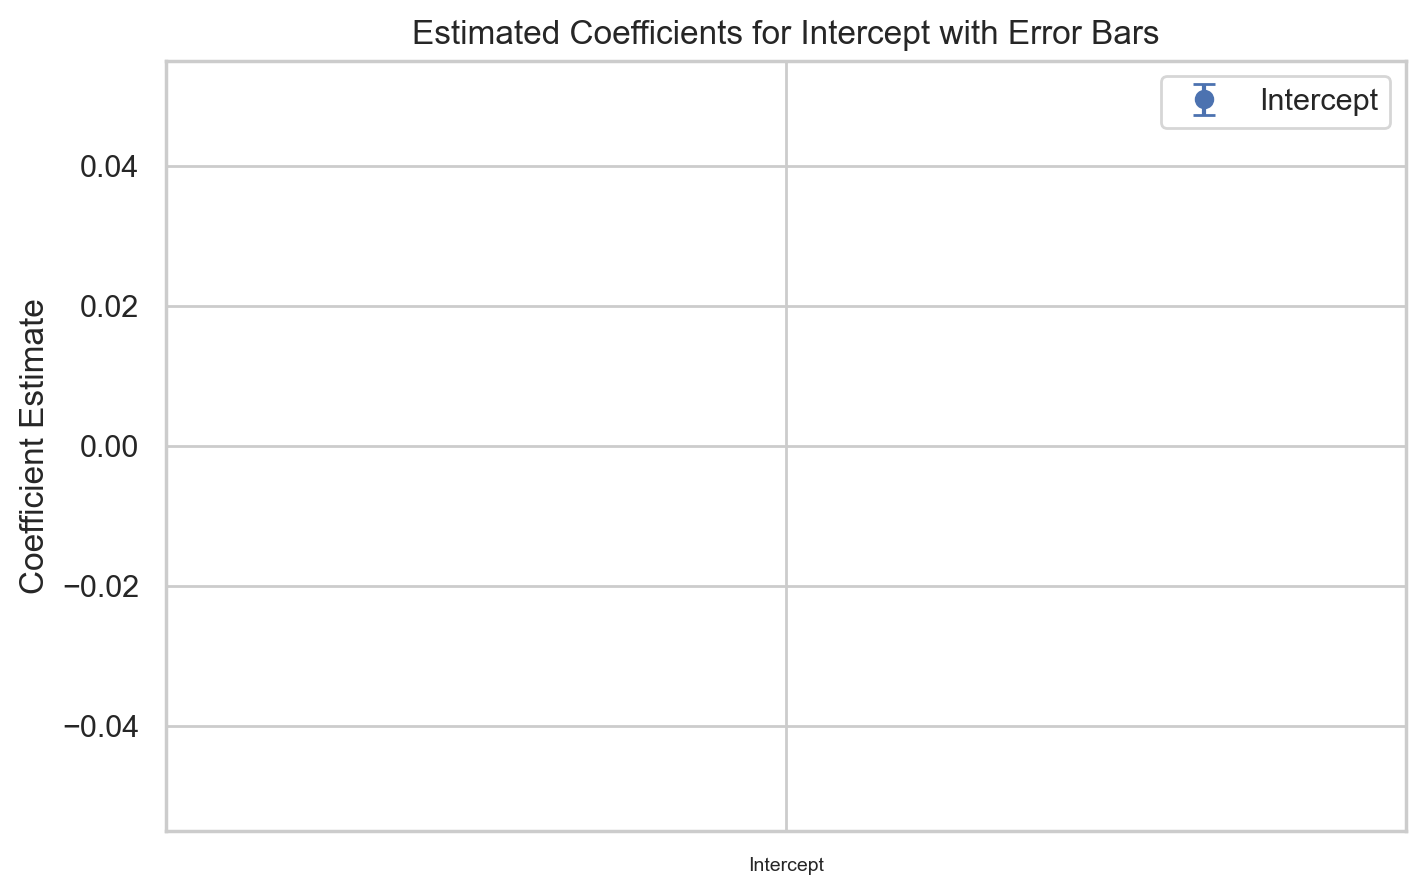

In [275]:

variables = poisson_est_coef['Variable'].unique()

# Loop through each variable and create individual plots
for variable in variables:
    subset = poisson_est_coef [poisson_est_coef ['Variable'] == variable]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    x = subset['Label']
    y = subset['Lower_boot']  # or 'Upper_boot' for Upper bound
    y_err = subset['Upper_boot'] - subset['Lower_boot']
    
    ax.errorbar(x, y, yerr=y_err, label=variable, marker='o', linestyle='None', capsize=4)

    ax.set_ylabel('Coefficient Estimate')
    ax.set_title(f'Estimated Coefficients for {variable} with Error Bars')
    ax.legend()
    # Change x-axis label size
    ax.tick_params(axis='x', labelsize=7,rotation=0)
    plt.show()

# Tree-based models

## Random forests

In [34]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 12


## Gradient-boosting model

In [65]:
from sklearn.ensemble import HistGradientBoostingRegressor

poisson_gbrt = Pipeline(
    [
        ("preprocessor", preprocessor1),
        ("regressor",HistGradientBoostingRegressor(loss="poisson", min_samples_leaf=500)),
    ]
)

# Fit the pipeline with training data
poisson_gbrt.fit(train, train["Frequency"], regressor__sample_weight=train["Exposure"])

# Predict on the test set
ypred_gbrt = poisson_gbrt.predict(test)

result = mean_poisson_deviance(test['Frequency'], ypred_gbrt,sample_weight=test['Exposure'])
print("Mean Poisson Deviance:", result)
print(" Relative decrease in deviance compared to baseline model ",1-result/dev_baseline_fm)


Mean Poisson Deviance: 0.4467307098421751
 Relative decrease in deviance compared to baseline model  0.06633164759733567


## Hyper-parameter tuning for tree-based models

# Investigating interaction effects using Friedman's H statistic

https://github.com/scikit-learn/scikit-learn/issues/22383

https://stats.stackexchange.com/questions/510510/intuitive-explanation-of-friedmans-h-statistic

Predictive learning via rule ensembles, Friedman, Popescu (2008)

Defining partial dependence function

Univariate partial dependence function + plot

In [164]:
def partial(model,var,df,figure=False,frac=1):
    df = df.sample(frac=frac) #Subsample data to lower running-time
    predictions = []
    values = df[var].drop_duplicates()
    values = np.sort(values)
    for val in values: 
          data = df.copy()
          data[var] = val 
          prediction = np.mean(model.predict(data))
          predictions.append(prediction)
    fig = plt.figure()
    plt.plot(values, predictions)
    plt.close() 
    return predictions,values,fig

#This yields the same result as calling the PartialDependenceDisplay function in scikit-learn e.g. by the following:
#from sklearn.inspection import PartialDependenceDisplay
#fig, ax = plt.subplots(figsize=(12, 6))
#disp = PartialDependenceDisplay.from_estimator(
#    poisson_gbrt, test, ["DrivAge"], ax=ax, line_kw={"color": "red"}
#)

    

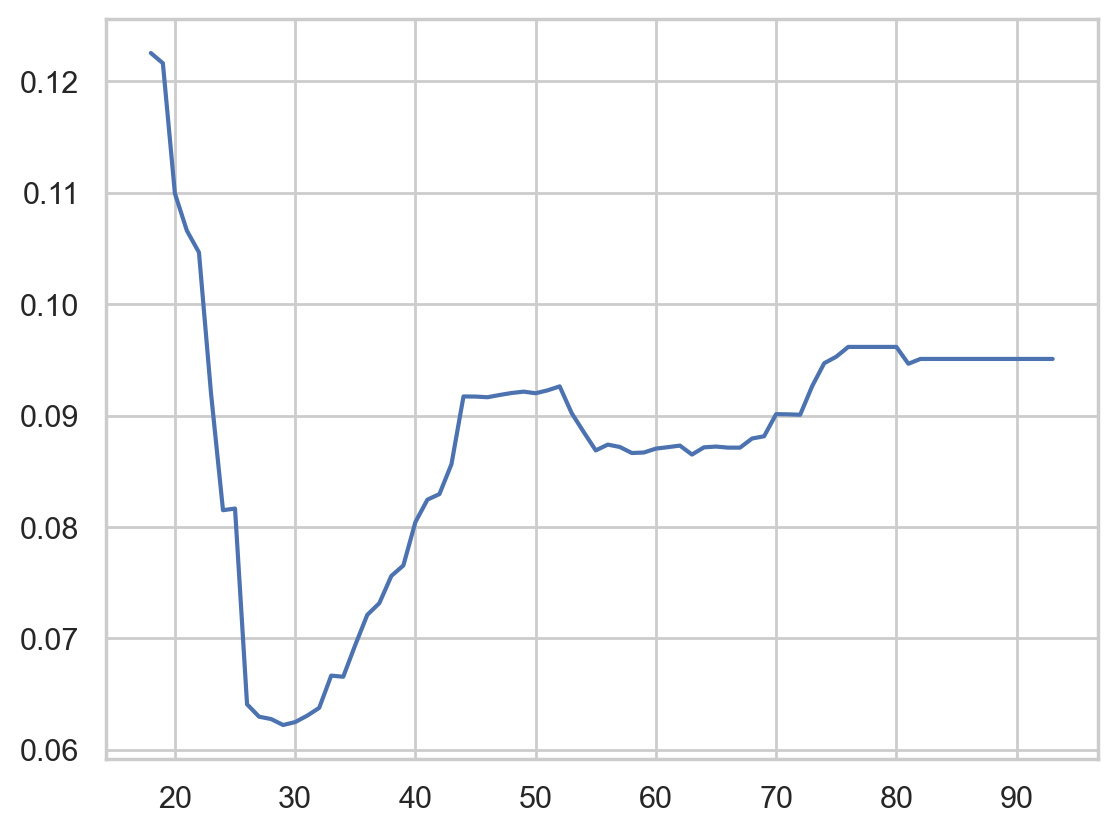

In [165]:

# Example with DriverAge using subsamples dataframe
partial(model = poisson_gbrt, var = "DrivAge",df=test,frac=0.1)[2]

Two-way partial dependence function

In [167]:
def two_way_partial(model, vars, df, frac=1):
    df = df.sample(frac=frac) #Subsample data to lower running-time
    predictions = []
    unique_values = df[vars].drop_duplicates()
    
    for idx, row in unique_values.iterrows():
        data = df.copy()
        for var, val in zip(vars, row):
            data[var] = val
        #print(data[vars])
        prediction = np.mean(model.predict(data))
        predictions.append(prediction)

    return predictions, unique_values

In [168]:
# Example with VehAge and Area
res = two_way_partial(model = poisson_gbrt, vars = ["VehAge","Area"],df=test,frac=0.1)
print(res[1:2])


(        VehAge Area
402357       9    C
279038      21    A
177815       2    C
255942       3    C
348249       2    E
...        ...  ...
57322       30    D
535899      38    A
469560      26    A
43222       99    F
149016      29    B

[191 rows x 2 columns],)


# Visualising and quantifying model fit